In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [ ]:
!kaggle competitions download -c ashrae-energy-prediction

100% 120M/120M [00:03<00:00, 46.2MB/s]

  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 42.8MB/s]
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 83.7MB/s]
 92% 153M/167M [00:02<00:00, 40.7MB/s]
100% 167M/167M [00:02<00:00, 60.9MB/s]
 89% 79.0M/88.4M [00:02<00:00, 28.1MB/s]
100% 88.4M/88.4M [00:02<00:00, 44.8MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 86.6MB/s]


In [ ]:
pip install pyunpack

In [ ]:
pip install patool

     |████████████████████████████████| 81kB 6.8MB/s 


In [ ]:
from pyunpack import Archive
Archive('/content/sample_submission.csv.zip').extractall('/content/')
Archive('/content/train.csv.zip').extractall('/content/')
Archive('/content/test.csv.zip').extractall('/content/')
Archive('/content/weather_train.csv.zip').extractall('/content/')
Archive('/content/weather_test.csv.zip').extractall('/content/')


In [ ]:
#importing Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns


In [ ]:
%%time

# Read data...
root = '/content'

train_df = (pd.read_csv(os.path.join(root, 'train.csv')))
weather_train_df = (pd.read_csv(os.path.join(root, 'weather_train.csv')))
test_df = (pd.read_csv(os.path.join(root, 'test.csv')))
weather_test_df = (pd.read_csv(os.path.join(root, 'weather_test.csv')))
building_meta_df = (pd.read_csv(os.path.join(root, 'building_metadata.csv')))
sample_submission = (pd.read_csv(os.path.join(root, 'sample_submission.csv')))

CPU times: user 18.8 s, sys: 2.54 s, total: 21.3 s
Wall time: 24.3 s


In [ ]:
#https://www.kaggle.com/corochann/ashrae-feather-format-for-fast-loading
#feather is used to reduce the size and load the dataset quickly
%%time

train_df.to_feather('train.feather')
test_df.to_feather('test.feather')
weather_train_df.to_feather('weather_train.feather')
weather_test_df.to_feather('weather_test.feather')
building_meta_df.to_feather('building_metadata.feather')
sample_submission.to_feather('sample_submission.feather')

CPU times: user 4.68 s, sys: 1.96 s, total: 6.64 s
Wall time: 5.67 s


In [ ]:
%%time

train_df = pd.read_feather('train.feather')
weather_train_df = pd.read_feather('weather_train.feather')
test_df = pd.read_feather('test.feather')
weather_test_df = pd.read_feather('weather_test.feather')
building_meta_df = pd.read_feather('building_metadata.feather')
sample_submission = pd.read_feather('sample_submission.feather')

CPU times: user 3.64 s, sys: 2.4 s, total: 6.04 s
Wall time: 3.26 s


In [ ]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])

# Function to reduce memory usage

In [ ]:
#https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)
weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
sample_submission = reduce_mem_usage(sample_submission)
building_meta_df = reduce_mem_usage(building_meta_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to 198.83 Mb (68.7% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [ ]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [ ]:
train_df.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,1.988706e+03
std,4.269133e+02,9.309921e-01,1.532159e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int16         
 1   meter          int8          
 2   timestamp      datetime64[ns]
 3   meter_reading  float32       
dtypes: datetime64[ns](1), float32(1), int16(1), int8(1)
memory usage: 289.2 MB


Weather data

In [ ]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [ ]:
weather_train_df.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139718.000000,70600.0,139660.000000,89484.0,129155.0,133505.0,139469.000000
mean,7.478977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.604744,0.000000,0.0,0.000000,NaN,NaN,NaN,0.000000
min,0.000000,-28.906250,0.0,-35.000000,-1.0,968.0,0.0,0.000000
25%,3.000000,7.199219,0.0,0.600098,0.0,1012.0,80.0,2.099609
50%,7.000000,15.000000,2.0,8.296875,0.0,1016.5,190.0,3.099609
75%,11.000000,22.203125,4.0,14.398438,0.0,1021.0,280.0,5.000000
max,15.000000,47.187500,9.0,26.093750,343.0,1046.0,360.0,19.000000


In [ ]:
weather_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int8   
 1   timestamp           139773 non-null  object 
 2   air_temperature     139718 non-null  float16
 3   cloud_coverage      70600 non-null   float16
 4   dew_temperature     139660 non-null  float16
 5   precip_depth_1_hr   89484 non-null   float16
 6   sea_level_pressure  129155 non-null  float16
 7   wind_direction      133505 non-null  float16
 8   wind_speed          139469 non-null  float16
dtypes: float16(7), int8(1), object(1)
memory usage: 3.1+ MB


Building Metadata

In [ ]:
building_meta_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [ ]:
building_meta_df.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.0000,355.000000
mean,6.952381,724.000000,92111.776398,inf,3.740234
std,5.003432,418.434583,110769.950997,31.0625,3.333984
min,0.000000,0.000000,283.000000,1900.0000,1.000000
25%,3.000000,362.000000,23012.000000,1949.0000,1.000000
50%,5.000000,724.000000,57673.000000,1970.0000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.0000,5.000000
max,15.000000,1448.000000,875000.000000,2017.0000,26.000000


In [ ]:
building_meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int8   
 1   building_id  1449 non-null   int16  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int32  
 4   year_built   675 non-null    float16
 5   floor_count  355 non-null    float16
dtypes: float16(2), int16(1), int32(1), int8(1), object(1)
memory usage: 27.0+ KB


In [ ]:
train_data = train_df.merge(building_meta_df,how='left',on='building_id')
train_data = train_data.merge(weather_train_df,how='left',on=['site_id','timestamp']) 

In [ ]:
train_data.shape

(20216100, 16)

In [ ]:
test_data = test_df.merge(building_meta_df,how='left',on='building_id')
test_data = test_data.merge(weather_test_df,how='left',on=['site_id','timestamp']) 

In [ ]:
test_data.shape

(41697600, 16)

In [ ]:
train_data.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


#EDA

##Analysis of missing values for every feature

year_built : 0.5999
floor_count : 0.8265
air_temperature : 0.0048
cloud_coverage : 0.4366
dew_temperature : 0.005
precip_depth_1_hr : 0.1854
sea_level_pressure : 0.0609
wind_direction : 0.0717
wind_speed : 0.0071


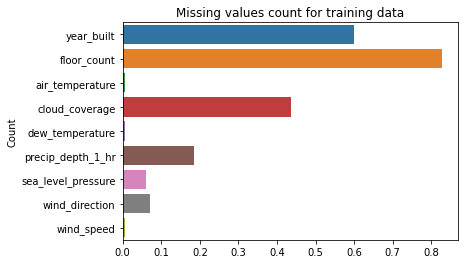

In [ ]:
features_with_na = [feature for feature in train_data.columns if train_data[feature].isnull().sum()>1]
scores = []
features = []
for feature in features_with_na:
    scores.append(np.round(train_data[feature].isnull().mean(),4))
    features.append(feature)
    print(feature+' : '+str(np.round(train_data[feature].isnull().mean(),4)))
sns.barplot(scores,features)
plt.ylabel('Count')
plt.title('Missing values count for training data')
plt.show()

year_built : 0.5899
floor_count : 0.8261
air_temperature : 0.0053
cloud_coverage : 0.4687
dew_temperature : 0.0063
precip_depth_1_hr : 0.1871
sea_level_pressure : 0.0604
wind_direction : 0.0714
wind_speed : 0.0072


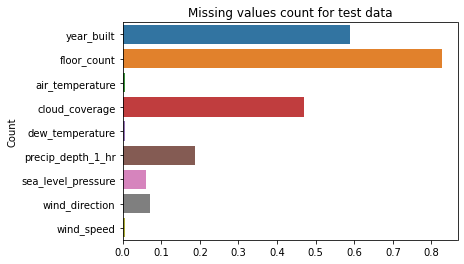

In [ ]:
features_with_na = [feature for feature in test_data.columns if test_data[feature].isnull().sum()>1]
scores = []
features = []
for feature in features_with_na:
    scores.append(np.round(test_data[feature].isnull().mean(),4))
    features.append(feature)
    print(feature+' : '+str(np.round(test_data[feature].isnull().mean(),4)))
sns.barplot(scores,features)
plt.ylabel('Count')
plt.title('Missing values count for test data')
plt.show()

* floor count having maximum missing values and next followed by year_bulit, cloud_coverage, precip_depth_1_hr for both training and testing data.

#Count of buildings based on meter type 

Number of buildings with meter  0 ( electricity ):  1413
Number of buildings with meter  1 ( chilledwater ):  498
Number of buildings with meter  2 ( steam ):  324
Number of buildings with meter  3 ( hotwater ):  145


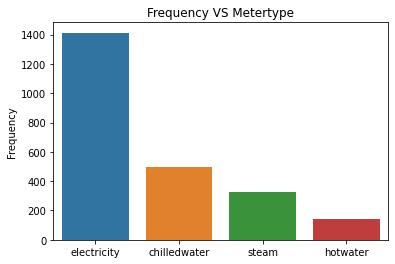

In [ ]:
data_building_meter = train_data.groupby('meter')['building_id'].nunique()
ind=['electricity','chilledwater','steam','hotwater']
for i in range(4):
    print('Number of buildings with meter ',i,'(',ind[i],'): ',data_building_meter[i])
data_building_meter.index=ind
sns.barplot(ind,data_building_meter.values)
plt.ylabel('Frequency')
plt.title('Frequency VS Metertype')
plt.show()

* Electricity meters are used in almost all building because electricity is needed in all buildings<br>
* Hotwater is used in less number when compared with other meters<br>
* All 3 usage are less in number because they are based on type of weather of that site   

#Count of buildings based on primary use

Total buildings for  Education :  549
Total buildings for  Entertainment/public assembly :  184
Total buildings for  Food sales and service :  5
Total buildings for  Healthcare :  23
Total buildings for  Lodging/residential :  147
Total buildings for  Manufacturing/industrial :  12
Total buildings for  Office :  279
Total buildings for  Other :  25
Total buildings for  Parking :  22
Total buildings for  Public services :  156
Total buildings for  Religious worship :  3
Total buildings for  Retail :  11
Total buildings for  Services :  10
Total buildings for  Technology/science :  6
Total buildings for  Utility :  4
Total buildings for  Warehouse/storage :  13




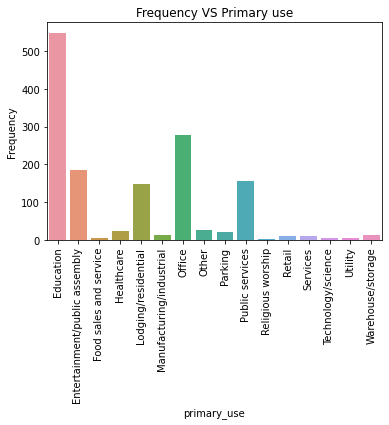

In [ ]:
df = train_data.groupby('primary_use')['building_id'].nunique()
ind = df.index
for i in range(len(ind)):
    print('Total buildings for ',ind[i],': ',df[i])
print('\n')
sns.barplot(ind,df.values)
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.title('Frequency VS Primary use')
plt.show()

* Most of the buildings are used for education purpose.<br>
* Buildings used for Entertainment/public assembly, Religious worship, Technology/science, Utility are less in number.

#Meter_reading VS Metertype

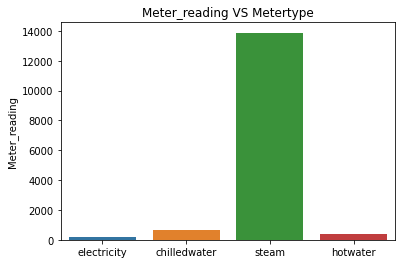

In [ ]:
df = train_data.groupby('meter')['meter_reading'].mean()
ind=['electricity','chilledwater','steam','hotwater']
data_building_meter.index=ind
sns.barplot(ind,df.values)
plt.ylabel('Meter_reading')
plt.title('Meter_reading VS Metertype')
plt.show()

* Steam meter readings are very high but they are used less in number when compared to electricity from previous analysis<br>
* Electricity meter readings are very low

##Stacked plot of meter_reading per site_id using primary_use

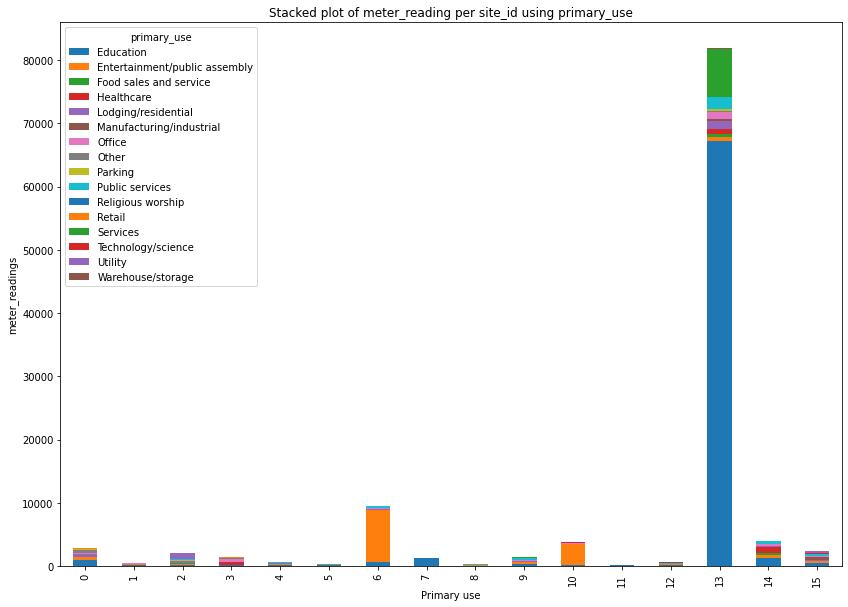

In [ ]:
df = train_data.groupby(['site_id','primary_use'])['meter_reading'].mean().unstack('primary_use')
df.plot(kind='bar', stacked=True,figsize=(14,10))
plt.xlabel('Primary use')
plt.ylabel('meter_readings')
plt.title('Stacked plot of meter_reading per site_id using primary_use')
plt.show()

* site_13 shows highest meter readings with main primary_use of education.<br>
* site_6 shows second highest meter readings with main primary_use of Retail.<br>
* site_id 1,5,8,11 are having least meter_readings.


##Stacked plot of meter_reading per meter using primary_use

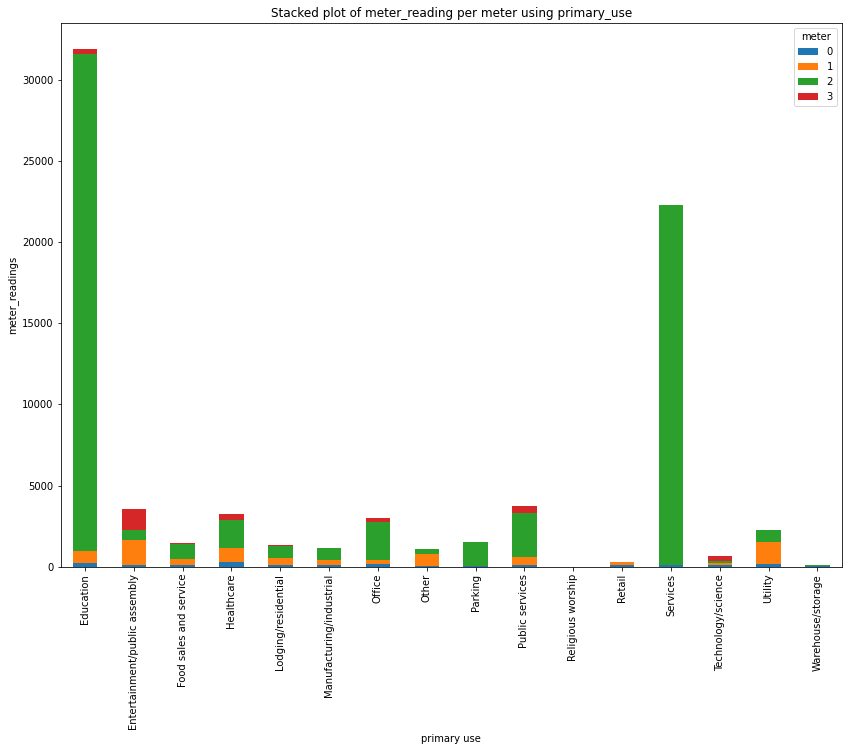

In [ ]:
df = train_data.groupby(['meter','primary_use'])['meter_reading'].mean().unstack('meter')
df.plot(kind='bar', stacked=True,figsize=(14,10))
plt.xlabel('primary use')
plt.ylabel('meter_readings')
plt.title('Stacked plot of meter_reading per meter using primary_use')
plt.show()

* From this plot we understand that why education,office and services buildings from previous plot are showing high values because they use steam as meter readings.<br>
* Electricity meters are also installed in most building types but mean meter_reading is very less<br>
* Chilled is also seen in almost all building types


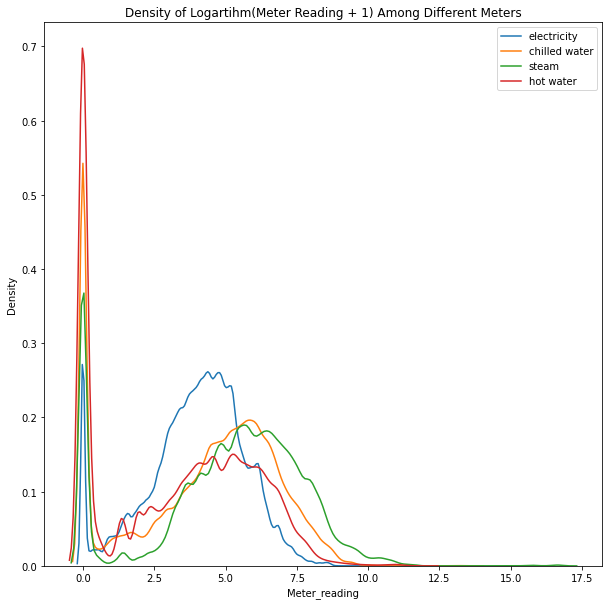

In [ ]:
plt.figure(figsize= (10,10))
unique_meters = sorted(train_data['meter'].unique().tolist())
for meter in unique_meters:
    data = train_data.query(f'meter=={meter}')
    sns.kdeplot(np.log1p(data['meter_reading']),label=meter)
    plt.xlabel("Meter_reading")
    plt.ylabel("Density")
    plt.legend(['electricity', 'chilled water', 'steam', 'hot water'])
    plt.title("Density of Logartihm(Meter Reading + 1) Among Different Meters")

* Most of the values of meter_reading which is target variable distributed around zero.

##Analysis of weather data

In [ ]:
def distant_plot(feature):
    '''plot dist curves for train weather data for the given column name'''
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.distplot(weather_train_df[feature], color='blue', ax=ax).set_title(feature, fontsize=16)
    plt.xlabel(feature, fontsize=15)
    plt.show()

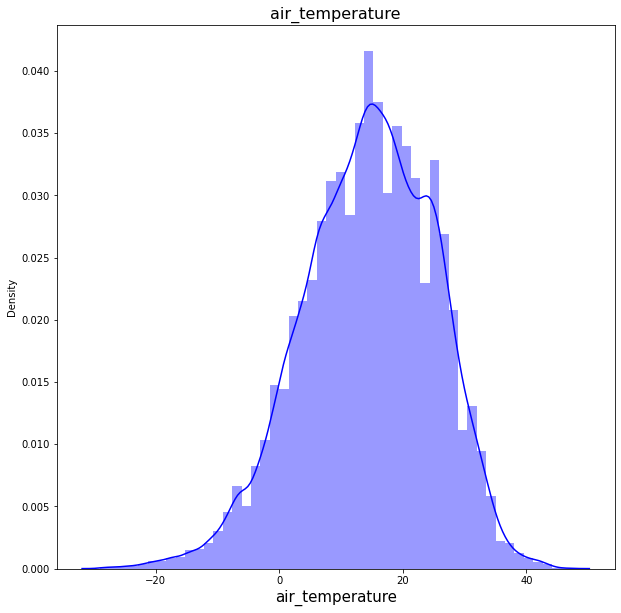

In [ ]:
distant_plot('air_temperature')

>Mean value of air temperature is 14.4 degree celsius.

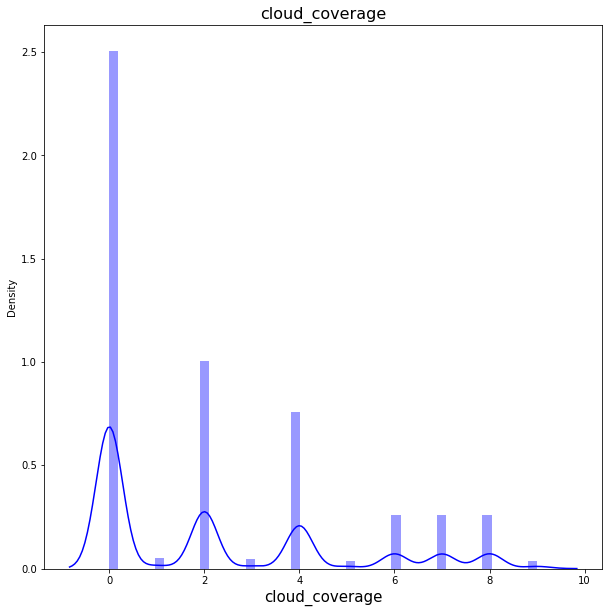

In [ ]:
distant_plot('cloud_coverage')

* cloud_coverage is measured between 0 to 9 scale 
and zero means it is a clear sky and 9 means it is rainy.<br>
* we observed that most of the cloud coverage is zero.

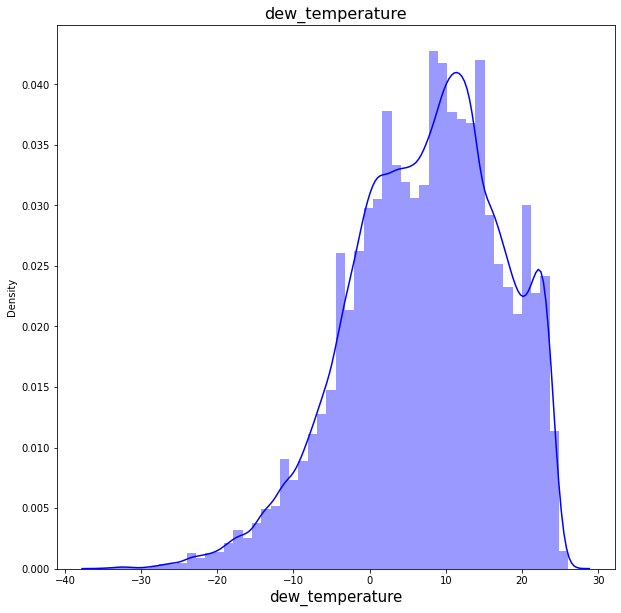

In [ ]:
distant_plot('dew_temperature')

>Most of dew temperature in all buildings is around 13 degree celsius.

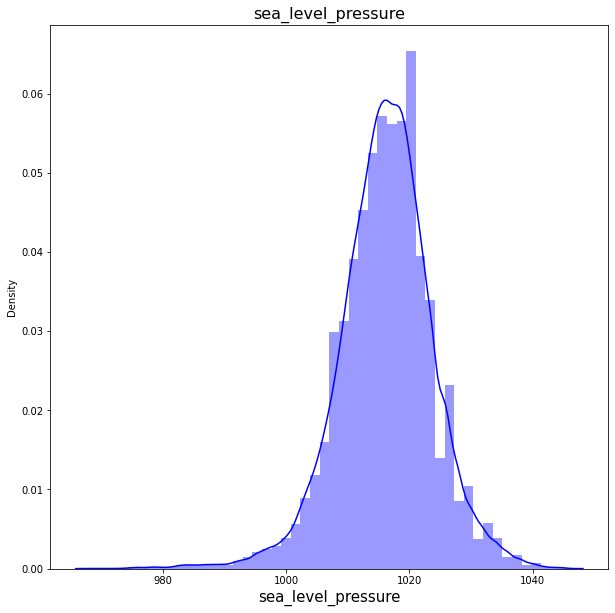

In [ ]:
distant_plot('sea_level_pressure')

Most of sea pressure is around 1019.

## Analysing building data

In [ ]:
def distant_plot(feature):
    '''plot dist curves for train weather data for the given column name'''
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.distplot(building_meta_df[feature], color='blue', ax=ax).set_title(feature, fontsize=16)
    plt.xlabel(feature, fontsize=15)
    plt.show()

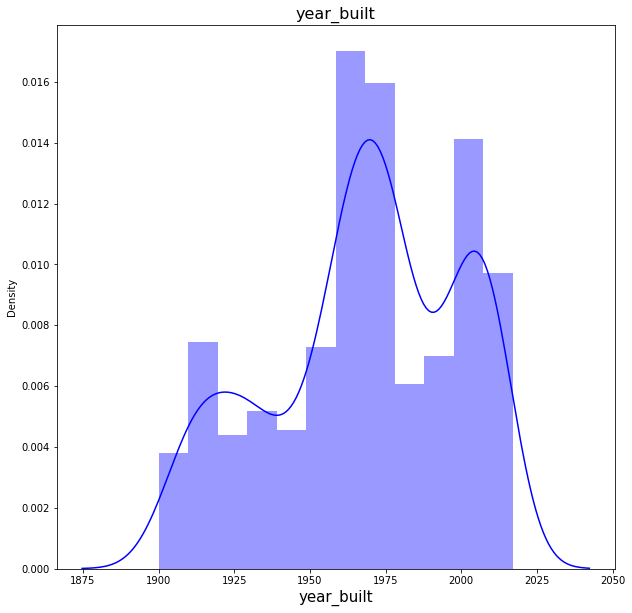

In [ ]:
distant_plot('year_built')

>Most of the buildings are around 1975.

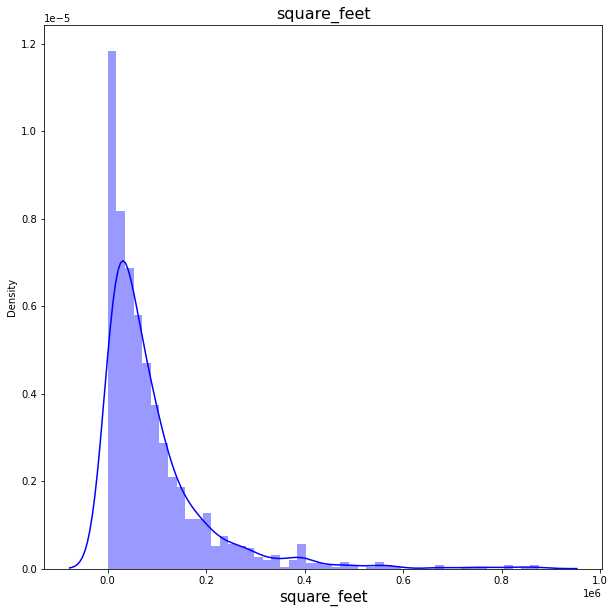

In [ ]:
distant_plot('square_feet')

* 80% of the square feet of buildings is around 100000. Very few buildings square feet is 800000.

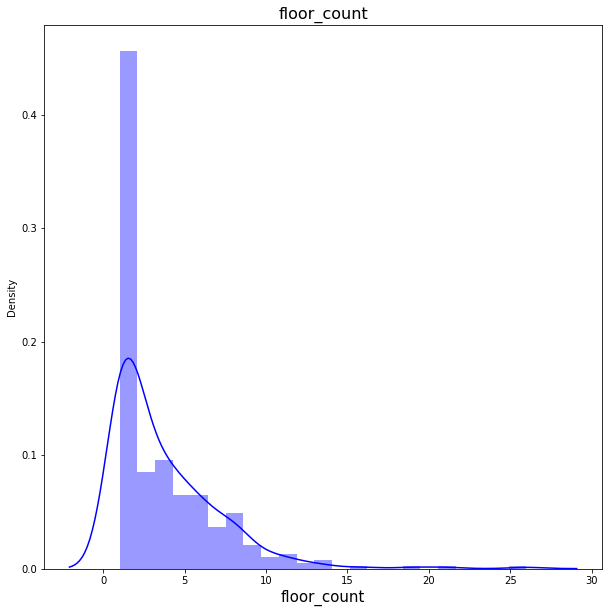

In [ ]:
distant_plot('floor_count')

>Most of the buildings have 2 floors.

#Analysis of meter reading Vs month based on meter type

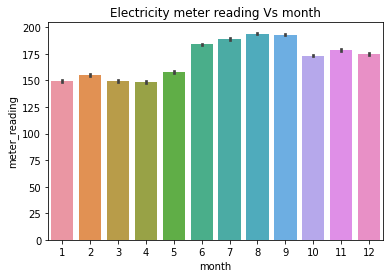

In [ ]:
meter_0 = train_data.query(f'meter=={0}')
meter_0['month'] = pd.to_datetime(train_data['timestamp']).dt.month
sns.barplot(data=meter_0,x='month',y='meter_reading')
plt.title('Electricity meter reading Vs month')
plt.ylabel('meter_reading')
plt.show()

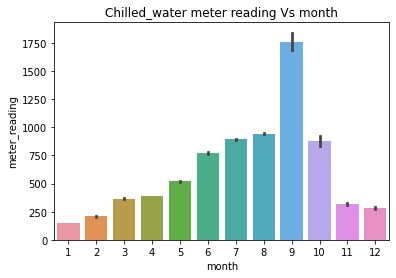

In [ ]:
meter_1 = train_data.query(f'meter=={1}')
meter_1['month'] = pd.to_datetime(train_data['timestamp']).dt.month
sns.barplot(data=meter_1,x='month',y='meter_reading')
plt.title('Chilled_water meter reading Vs month')
plt.ylabel('meter_reading')
plt.show()

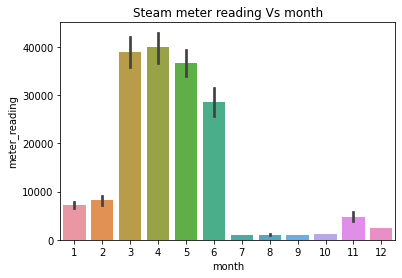

In [ ]:
meter_2 = train_data.query(f'meter=={2}')
meter_2['month'] = pd.to_datetime(train_data['timestamp']).dt.month
sns.barplot(data=meter_2,x='month',y='meter_reading')
plt.title('Steam meter reading Vs month')
plt.ylabel('meter_reading')
plt.show()

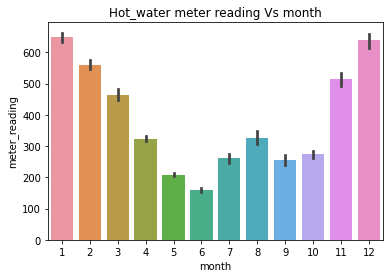

In [ ]:
meter_4 = train_data.query(f'meter=={3}')
meter_4['month'] = pd.to_datetime(train_data['timestamp']).dt.month
sns.barplot(data=meter_4,x='month',y='meter_reading')
plt.title('Hot_water meter reading Vs month')
plt.ylabel('meter_reading')
plt.show()

* We observe some seasonality varitions in usage of meter type.<br>
* Electricity meter readings are high during 6,7,8,9 months.<br>
* Chilled water meter readings are low duing winter and peak at september.<br>
* Steam meter readings are high during summer.<br>
* Hot meter readings are low during summer.<br> 



#Analysis of meter reading Vs weekday based on meter type

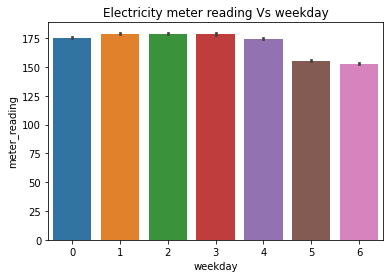

In [ ]:
meter_0 = train_data.query(f'meter=={0}')
meter_0['weekday'] = pd.to_datetime(train_data['timestamp']).dt.weekday
sns.barplot(data=meter_0,x='weekday',y='meter_reading')
plt.title('Electricity meter reading Vs weekday')
plt.ylabel('meter_reading')
plt.show()

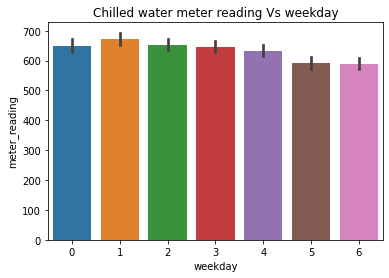

In [ ]:
meter_1 = train_data.query(f'meter=={1}')
meter_1['weekday'] = pd.to_datetime(train_data['timestamp']).dt.weekday
sns.barplot(data=meter_1,x='weekday',y='meter_reading')
plt.title('Chilled water meter reading Vs weekday')
plt.ylabel('meter_reading')
plt.show()

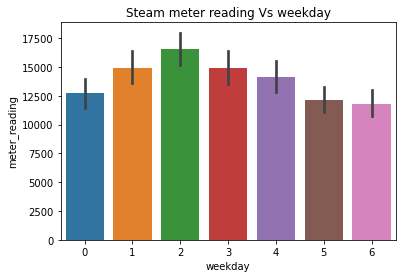

In [ ]:
meter_2 = train_data.query(f'meter=={2}')
meter_2['weekday'] = pd.to_datetime(train_data['timestamp']).dt.weekday
sns.barplot(data=meter_2,x='weekday',y='meter_reading')
plt.title('Steam meter reading Vs weekday')
plt.ylabel('meter_reading')
plt.show()

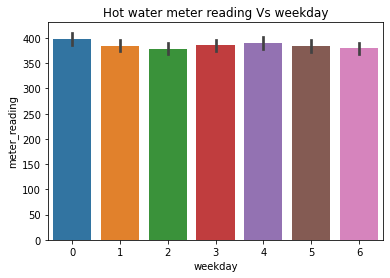

In [ ]:
meter_3 = train_data.query(f'meter=={3}')
meter_3['weekday'] = pd.to_datetime(train_data['timestamp']).dt.weekday
sns.barplot(data=meter_3,x='weekday',y='meter_reading')
plt.title('Hot water meter reading Vs weekday')
plt.ylabel('meter_reading')
plt.show()

* We found that meter readings are low at weekend when compared to the weekday.

#Analysis of meter reading Vs Hour based on meter type

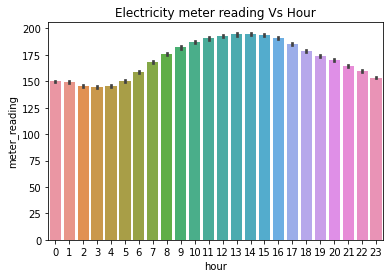

In [ ]:
meter_0 = train_data.query(f'meter=={0}')
meter_0['hour'] = pd.to_datetime(train_data['timestamp']).dt.hour
sns.barplot(data=meter_0,x='hour',y='meter_reading')
plt.title('Electricity meter reading Vs Hour')
plt.ylabel('meter_reading')
plt.show()

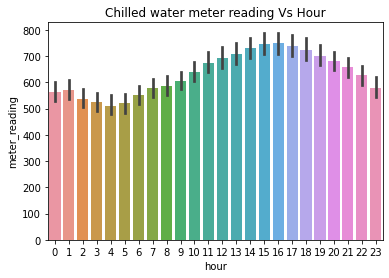

In [ ]:
meter_1 = train_data.query(f'meter=={1}')
meter_1['hour'] = pd.to_datetime(train_data['timestamp']).dt.hour
sns.barplot(data=meter_1,x='hour',y='meter_reading')
plt.title('Chilled water meter reading Vs Hour')
plt.ylabel('meter_reading')
plt.show()

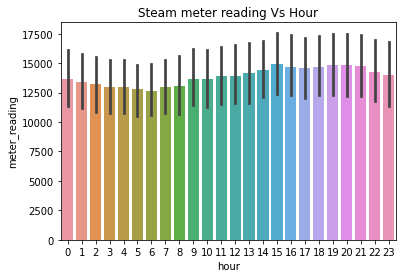

In [ ]:
meter_2 = train_data.query(f'meter=={2}')
meter_2['hour'] = pd.to_datetime(train_data['timestamp']).dt.hour
sns.barplot(data=meter_2,x='hour',y='meter_reading')
plt.title('Steam meter reading Vs Hour')
plt.ylabel('meter_reading')
plt.show()

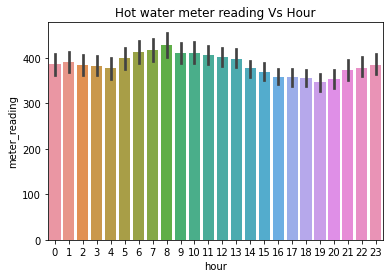

In [ ]:
meter_3 = train_data.query(f'meter=={3}')
meter_3['hour'] = pd.to_datetime(train_data['timestamp']).dt.hour
sns.barplot(data=meter_3,x='hour',y='meter_reading')
plt.title('Hot water meter reading Vs Hour')
plt.ylabel('meter_reading')
plt.show()

* Electricity and chilled water meter readings starts increasing after 9 AM and then decreasing after evening 6 PM.<br>
* Hot water meter readings are high during morning hours.  

## Analysis based on primary_use for each site_id with electricity meter type

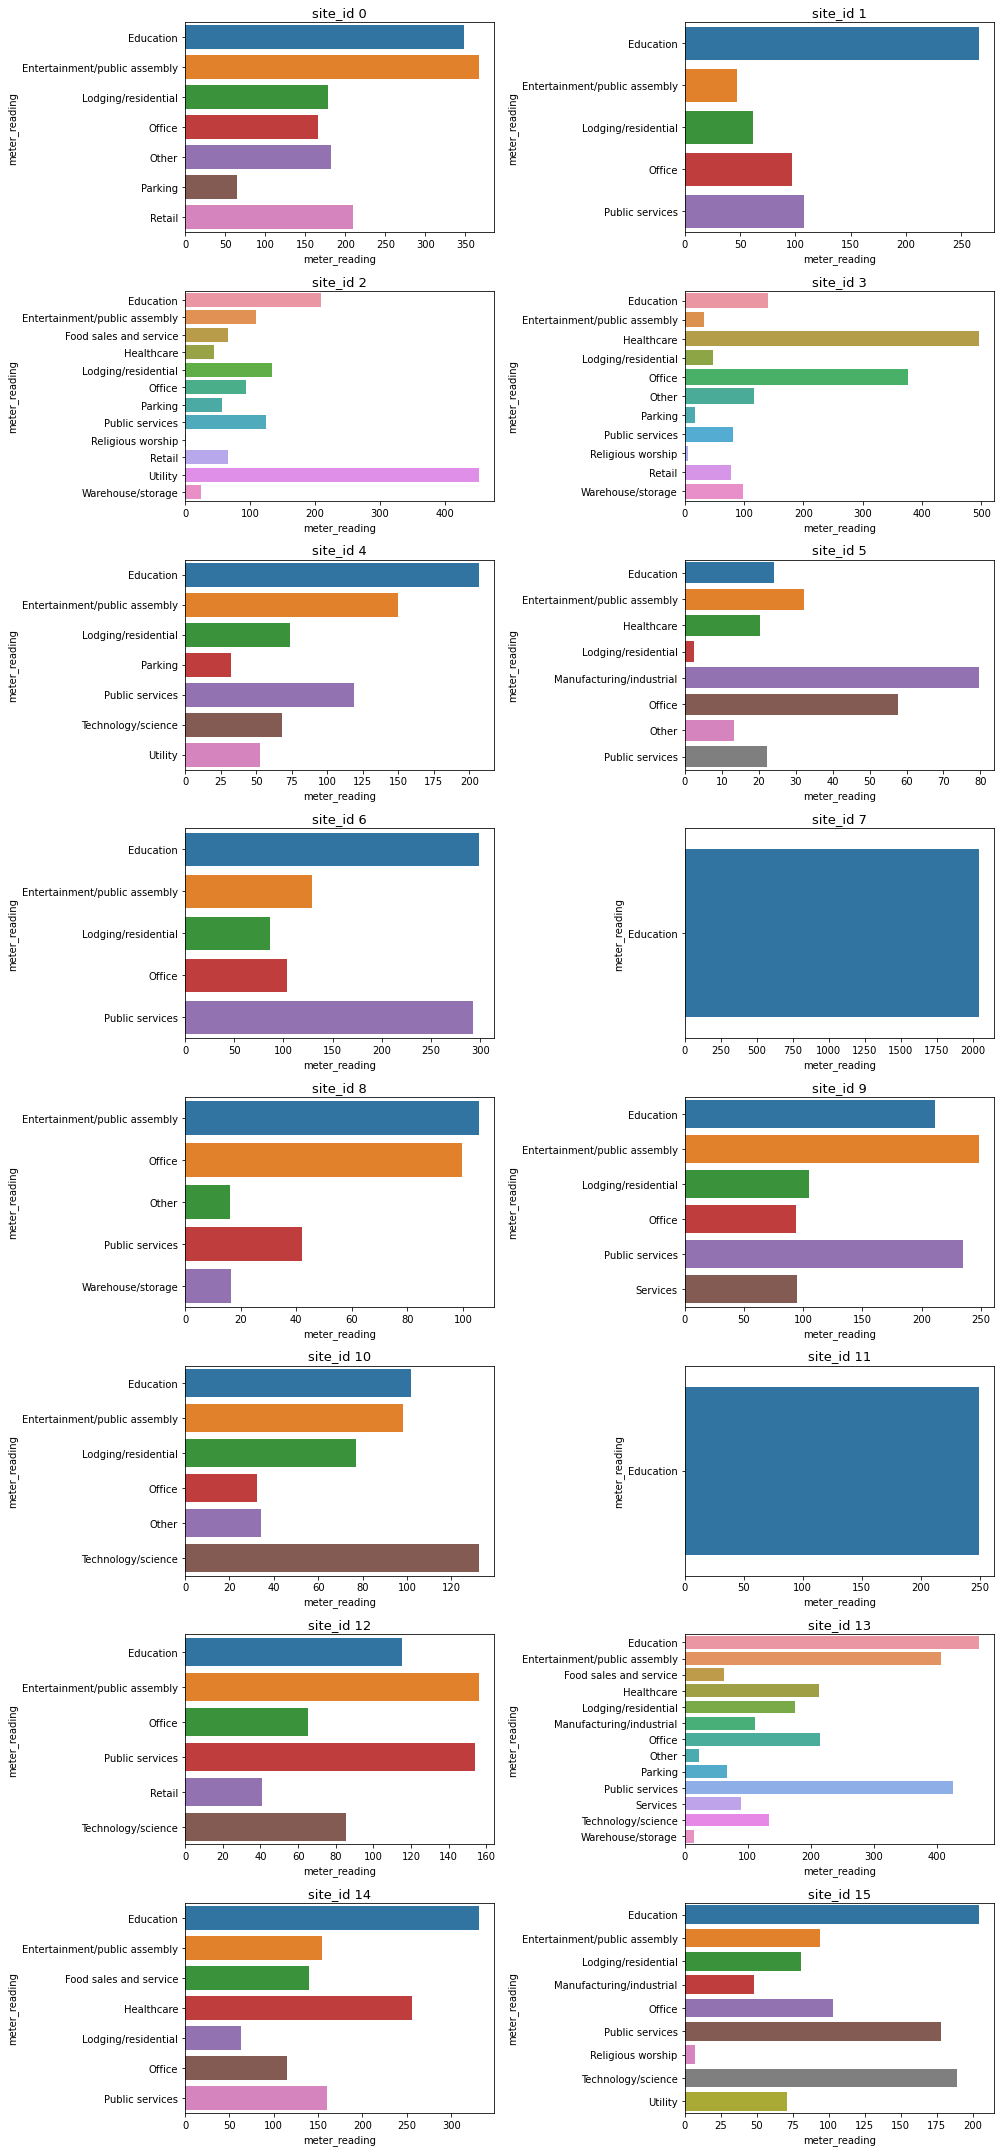

In [ ]:
n = 0
fig, axes = plt.subplots(8,2,figsize=(14,30))
for row in range(8):
    for col in range(2):
        d = train_data.query(f'site_id=={n} and meter=={0}')
        d = d.groupby('primary_use')['meter_reading'].mean().reset_index()
        sns.barplot(data=d,y='primary_use',x='meter_reading',ax=axes[row,col])
        axes[row,col].set_title('site_id {}'.format(n), fontsize=13)
        axes[row,col].set_ylabel('meter_reading')
        plt.tight_layout()
        n = n+1

* Education type buildings are present in all sites except site_id 8 for electricity meter type.<br>
* Although entertainment/public assembly and retail buildings are less in number but are consuming electricity at a large scale in site_id 0.<br>
* site_id 1 having higher consumption Electricity buildings.<br>
* Although utility buildings are less in count but it is having the highest electricity consumption for site_id 2.<br>
* Healthcare industry has the highest electrical energy consumption for site_id 3.<br>
* site_id 4 has highest electrical usage for education building type followed by entertainment/public assembly.<br>
* site_id 5 has highest electrical usage for Manufacturing/industrial building type followed by office.<br>
* site_id 6 having highest electricity consumption of education and public services building type.<br>
* site_id 7 and 11 are showing highest electricity meter reading values with only education building type.<br>
* site_id 8 having highest electricity usage of entertainment/public assembly and office building type.<br>
* site_id 9 plot showing that entertainment/public assembly and public services buildings which are lesser in number are consuming more electrcity than the educational buildings which are present in higher numbers.<br>
* site_id 10 has highest electricity consumption of Technology/science eventhough they are less in count.<br>
* site_id 12 having highest electricity consumption of entertainment/public assembly and public services building type.<br>
* site_id 13 have all types of buildings with highest electricity consumption of education buildings followed by entertainment/assembly and public services.<br>
* site_id 14 having highest electricity consumption of education buildings.<br>
* site_15 has highest electrical usage for education building type followed by Technology/science and public services.<br>




## Analysis based on primary_use for each site_id with chilled water meter type

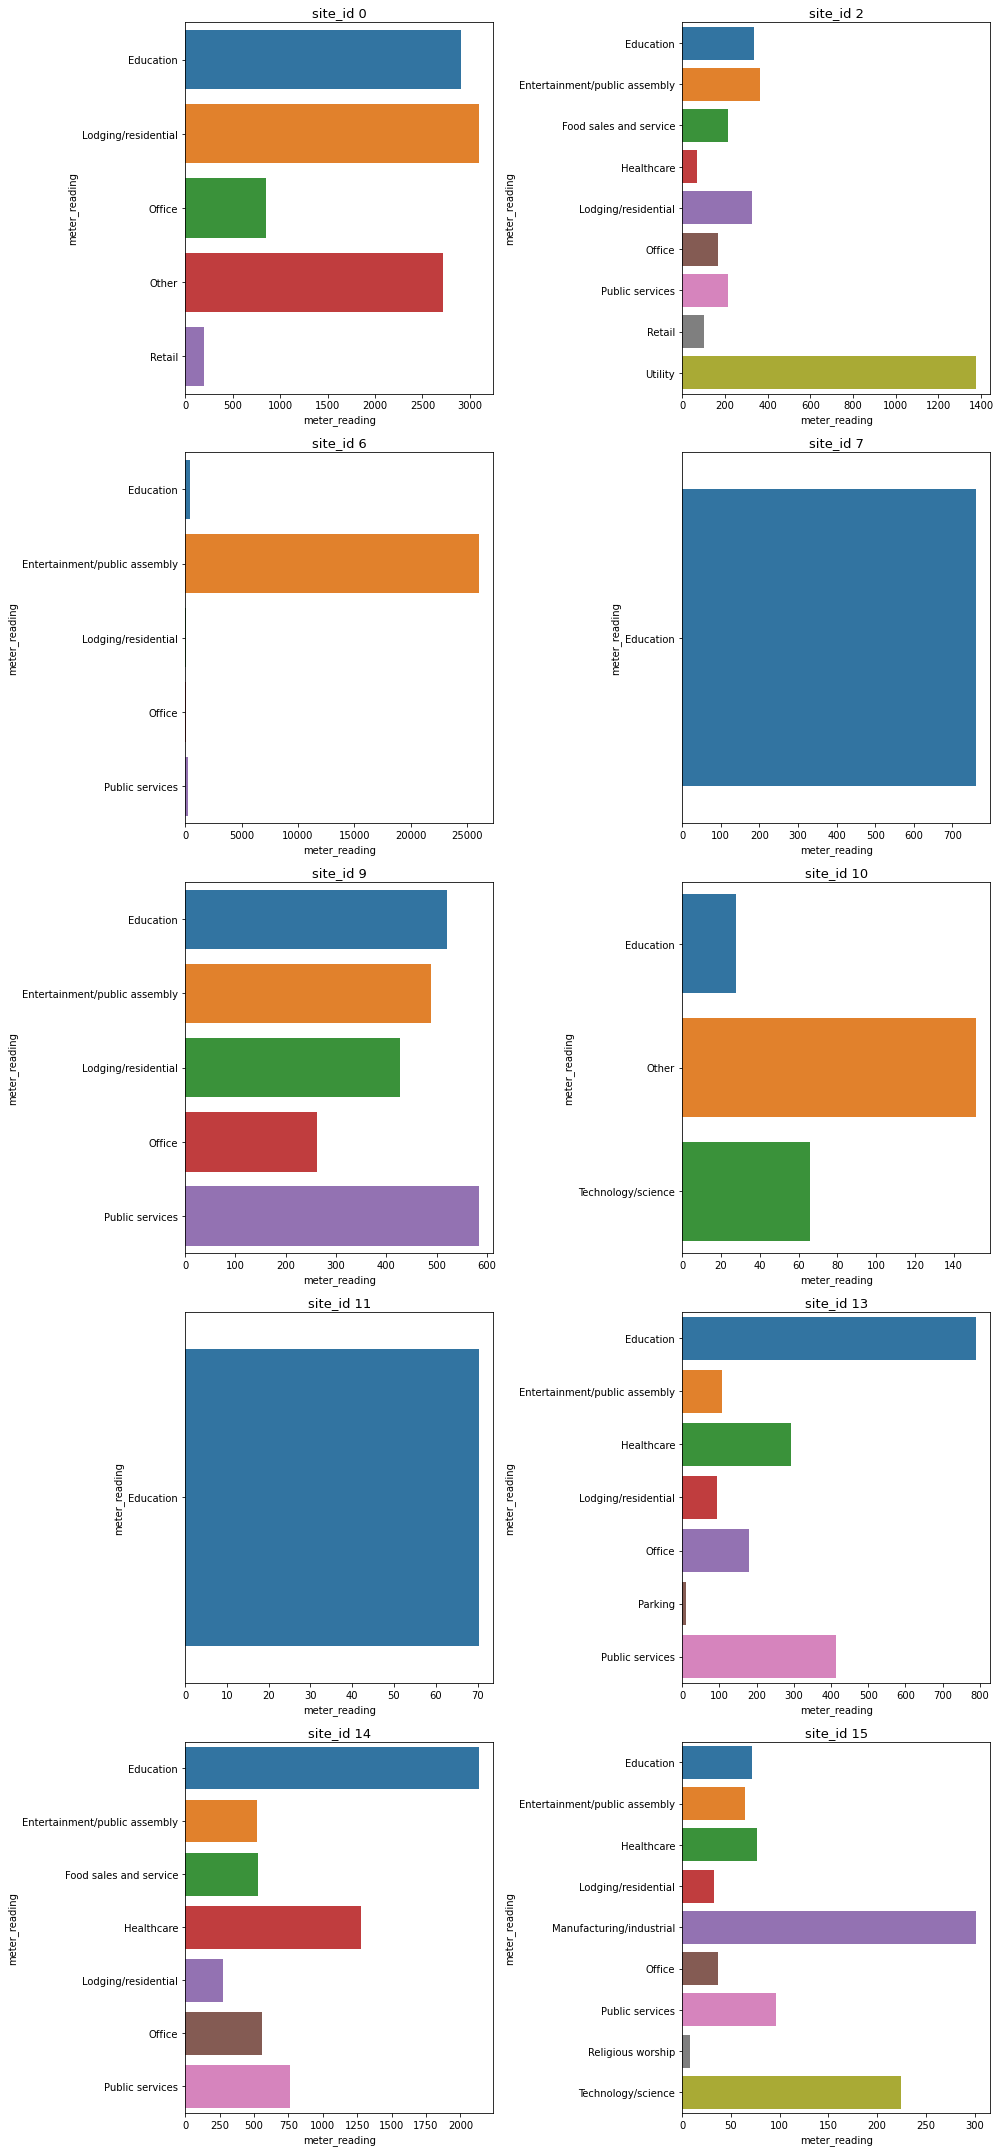

In [ ]:
id = [0,2,6,7,9,10,11,13,14,15]
n = 0
fig, axes = plt.subplots(5,2,figsize=(14,30))
for row in range(5):
    for col in range(2):
        d = train_data.query(f'site_id=={id[n]} and meter=={1}')
        d = d.groupby('primary_use')['meter_reading'].mean().reset_index()
        sns.barplot(data=d,y='primary_use',x='meter_reading',ax=axes[row,col])
        axes[row,col].set_title('site_id {}'.format(id[n]), fontsize=13)
        axes[row,col].set_ylabel('meter_reading')
        plt.tight_layout()
        n = n+1

* Education, lodging/residential, other having higher consumption of chilled water for site_id 0.<br>
* Utility is having the higher chilledwater consumption for site_id 2.<br>
* Entertainment/public assembly having higher chilled water usage for site_id 6.<br>
*  site_id 7,11 having chilled water usage with only education building type.<br>
* site_id 9 has highest chilled water usage for public services buildings.<br>
* site_id 10 has highest chilled water usage for other buildings.<br>
* site_id 13,14 have highest chilled water usage for education buildings.<br>
* site_id 15 has highest chilled water usage for manufacturing/industrial buildings followed by technology/science eventhough they are less in number.

## Analysis based on primary_use for each site_id with steam meter type

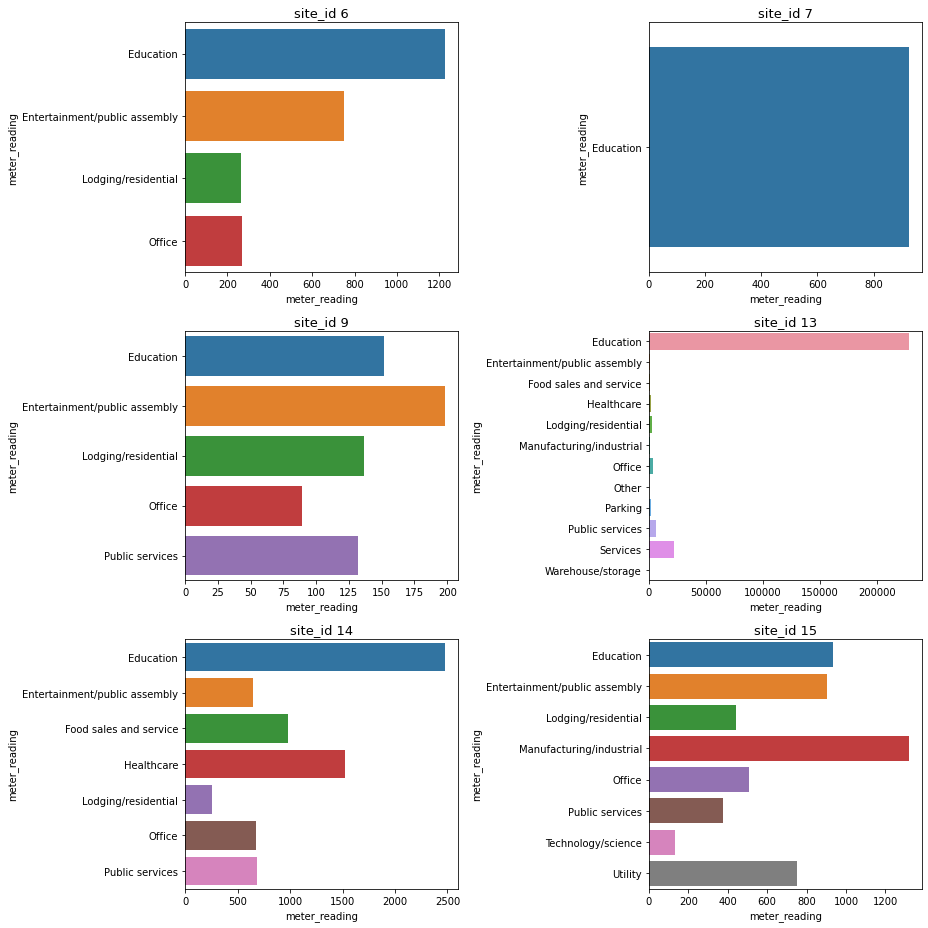

In [ ]:
id = [6,7,9,13,14,15]
n = 0
fig, axes = plt.subplots(3,2,figsize=(13,13))
for row in range(3):
    for col in range(2):
        d = train_data.query(f'site_id=={id[n]} and meter=={2}')
        d = d.groupby('primary_use')['meter_reading'].mean().reset_index()
        sns.barplot(data=d,y='primary_use',x='meter_reading',ax=axes[row,col])
        axes[row,col].set_title('site_id {}'.format(id[n]), fontsize=13)
        axes[row,col].set_ylabel('meter_reading')
        plt.tight_layout()
        n = n+1

* site_id 6,13,14 have highest steam usage for education buildings.<br>
* site_id 7 is showing highest steam meter reading values with only education building type.<br>
* site_id 9 plot showing that entertainment/public assembly which are lesser in number are consuming more steam than the educational buildings which are present in higher numbers.<br>
* site_id 15 has highest steam usage for manufacturing/industrial bulidings.<br>

## Analysis based on primary_use for each site_id with hot water meter type

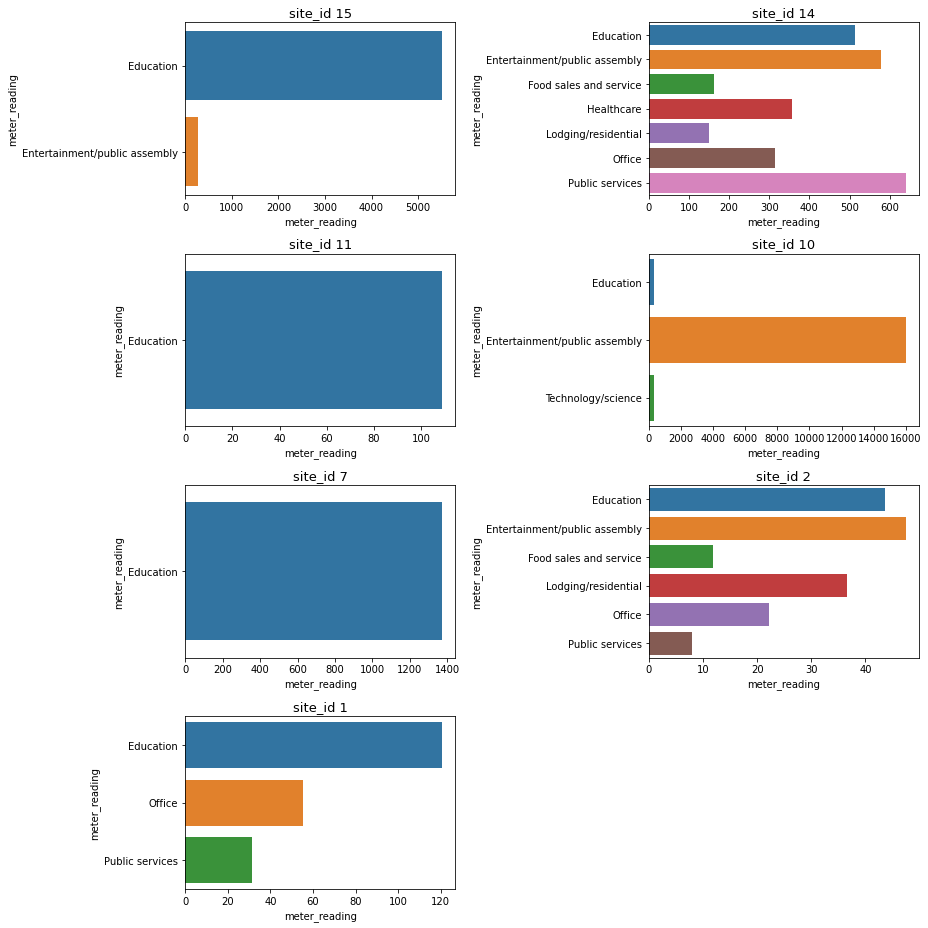

In [ ]:
id = [1,2,7,10,11,14,15]
n = 6
fig, axes = plt.subplots(4,2,figsize=(13,13))
fig.delaxes(axes[3,1])
for row in range(4):
    for col in range(2):
        d = train_data.query(f'site_id=={id[n]} and meter=={3}')
        d = d.groupby('primary_use')['meter_reading'].mean().reset_index()
        sns.barplot(data=d,y='primary_use',x='meter_reading',ax=axes[row,col])
        axes[row,col].set_title('site_id {}'.format(id[n]), fontsize=13)
        axes[row,col].set_ylabel('meter_reading')
        plt.tight_layout()
        n = n-1

* site_id 1 has highest hot water usage for education buildings.<br>
* site_id 7,11,15 are showing highest steam meter reading values with only education building type.<br>
* site_id 2 plot showing that entertainment/public assembly which are lesser in number are consuming more hot water readings than the educational buildings which are present in higher numbers.<br>
* site_id 10 has highest hot water usage for entertainment/public assembly buildings.<br>
* site_14 has highest hot water usage for public services.

#Analysis based on hour of day for each site_id

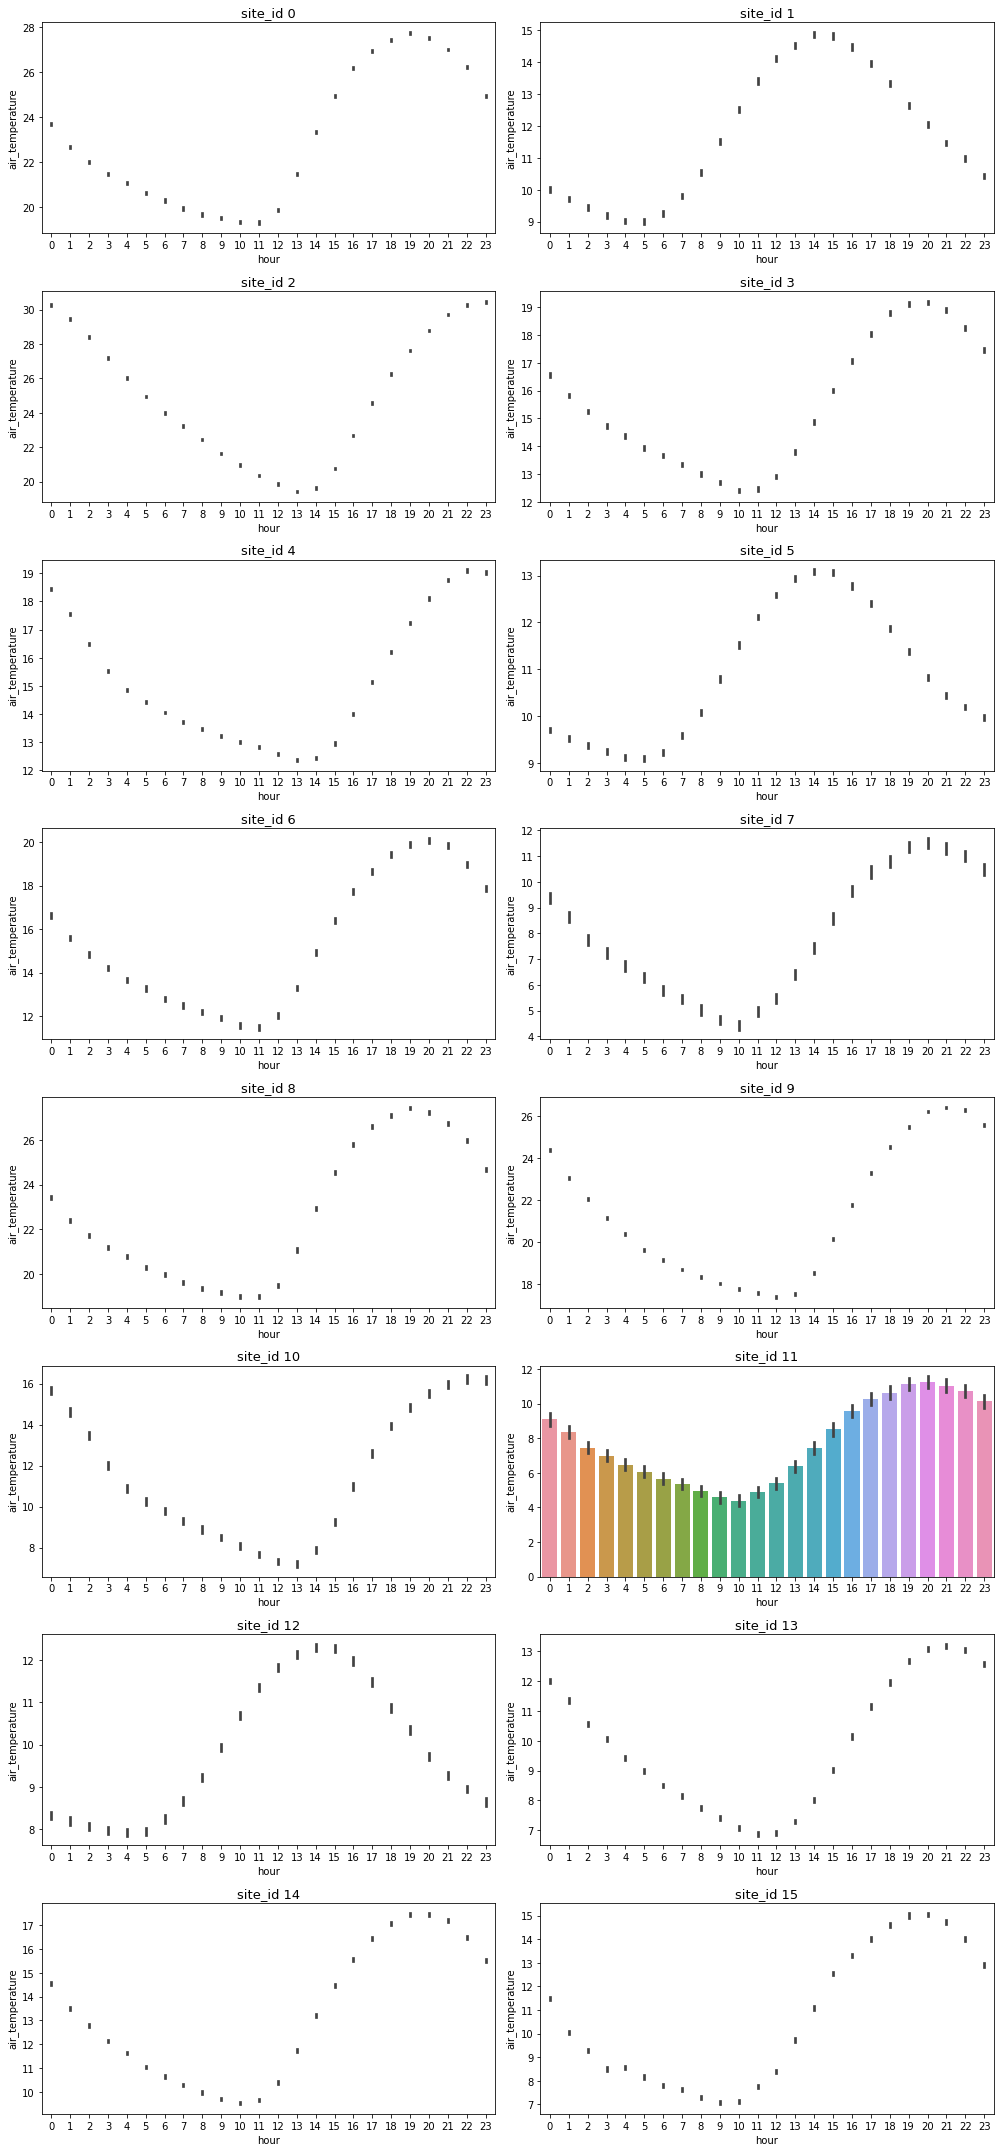

In [ ]:
n = 0
fig, axes = plt.subplots(8,2,figsize=(14,30))
for row in range(8):
    for col in range(2):
        d = train_data.query(f'site_id=={n}')
        d['hour'] = pd.to_datetime(d['timestamp']).dt.hour
        sns.barplot(data=d,x='hour',y='air_temperature',ax=axes[row,col])
        axes[row,col].set_title('site_id {}'.format(n), fontsize=13)
        axes[row,col].set_ylabel("air_temperature")
        plt.tight_layout()
        n = n+1

* site_id 0,2,3,4,6,7,8,9,10,11,13,14,15 plots shows that weather timestamp doesn't follow with the local timestamp as it shows peak during time hoours.<br>
* only site_id 1,5,12 are following local timestamp as it shows peak during afternoon hours.

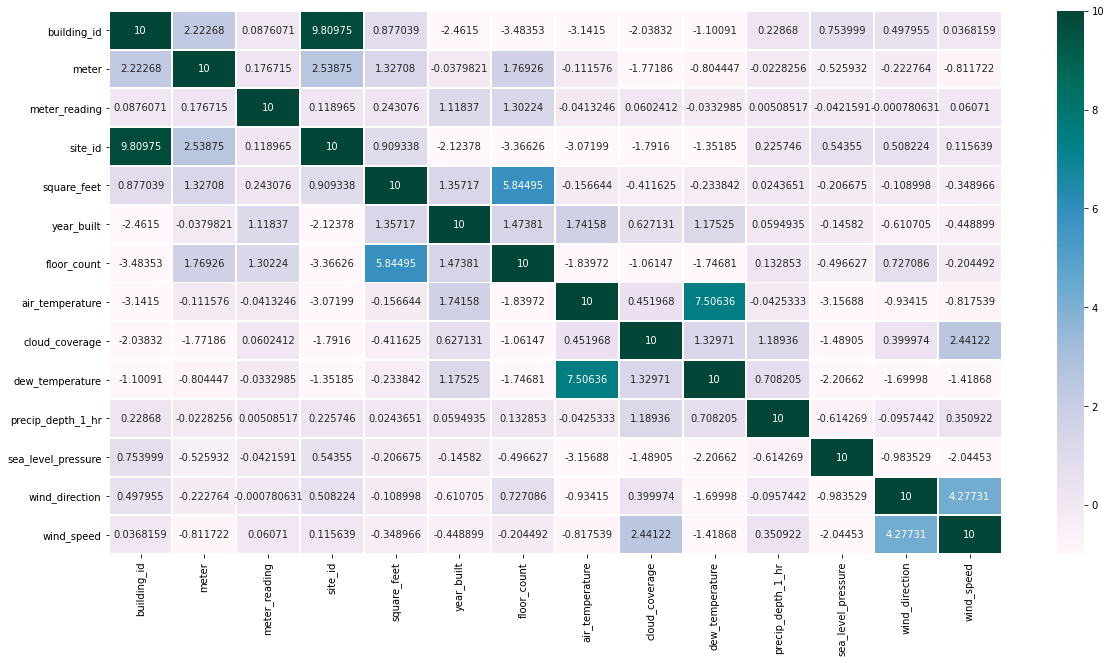

In [ ]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(train_data.corr()*10,vmin=-1,vmax=10,linewidths=1,annot=True,annot_kws={"size": 10},fmt="g",ax=ax,cmap='PuBuGn')

* building id is highly correlated with site_id.<br>
* air_temperature is highly correlated with dew_temperture.<br>
* square_feet is correlated with floor_count.<br>
* Most of the features are less in correlation with meter reading.<br>
* wind speed is in correlation with wind direction and cloud_coverage.<br>

#Plots of all buildings of meter readings based on meter type

In [ ]:
def all_building_meter_plot(meter):
    df = train_data.query(f'meter=={meter}')
    df['day'] = pd.to_datetime(df['timestamp']).dt.dayofyear
    d = df.groupby('day')['meter_reading'].mean()
    plt.figure(figsize=(14,7))
    plt.xlabel('Day of Year')
    plt.ylabel('meter_reading')
    plt.title('Meter_reading for all buiding with meter '+str(meter))
    plt.plot(d)
    return

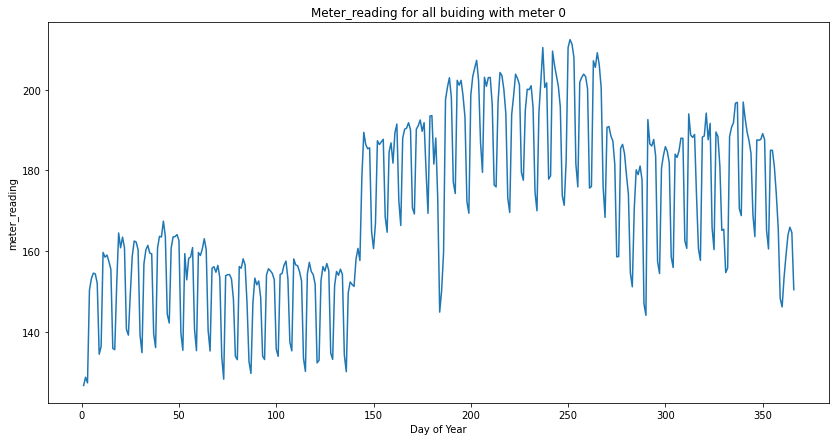

In [ ]:
meter = 0
all_building_meter_plot(meter)

* Electricity meter readings vary from 130 kWh to 210kWh.<br>
* For first 150 days there are low electricity meter readings.

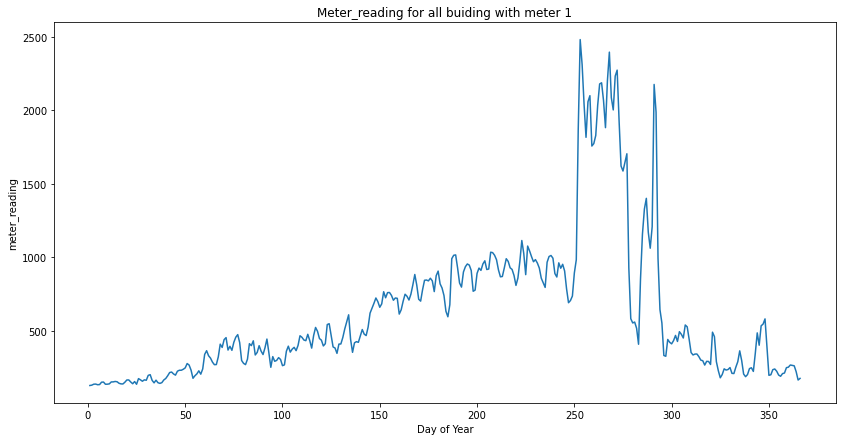

In [ ]:
all_building_meter_plot(1)

* Chilled water vary from 250kWh to 2500kWh<br>
* Chilled water meter readings are high between 250 and 300 days

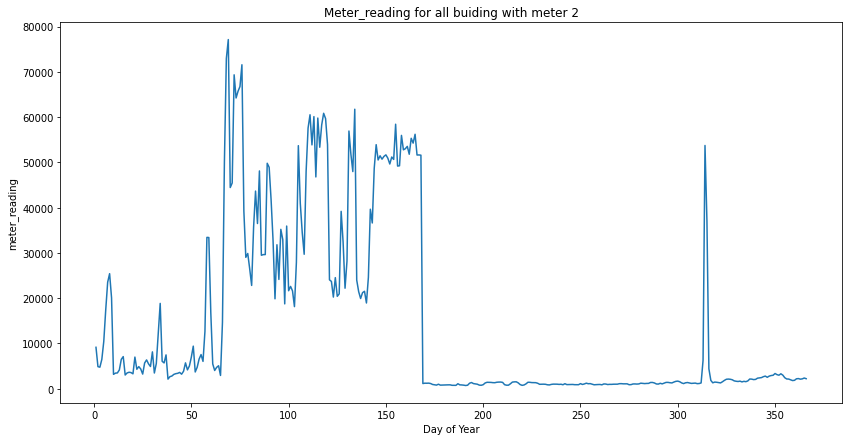

In [ ]:
all_building_meter_plot(2)

* Steam readings are more first 170 days and between 310 to 320 days.<br>
* Steam readings vary from 5MWh to 80MWh and these readings are very high.<br>
* There is abnormal increase due to the presence of outliers between 310 to 320 days. So,we have to check based on site_id to find outliers.

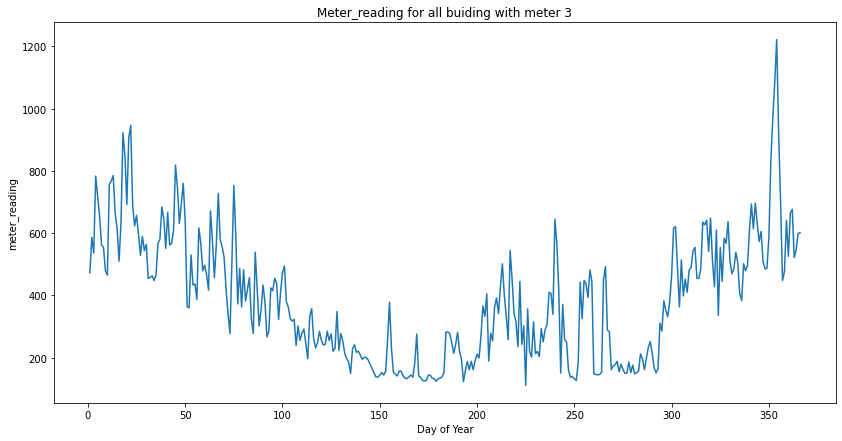

In [ ]:
all_building_meter_plot(3)

* Hot water vary from 180kWh to 1200kWh<br>
* Hot water reading is low during summer(100th to 200th day)

In [ ]:
train_data['log_meter_reading'] = np.log1p(train_data['meter_reading'])

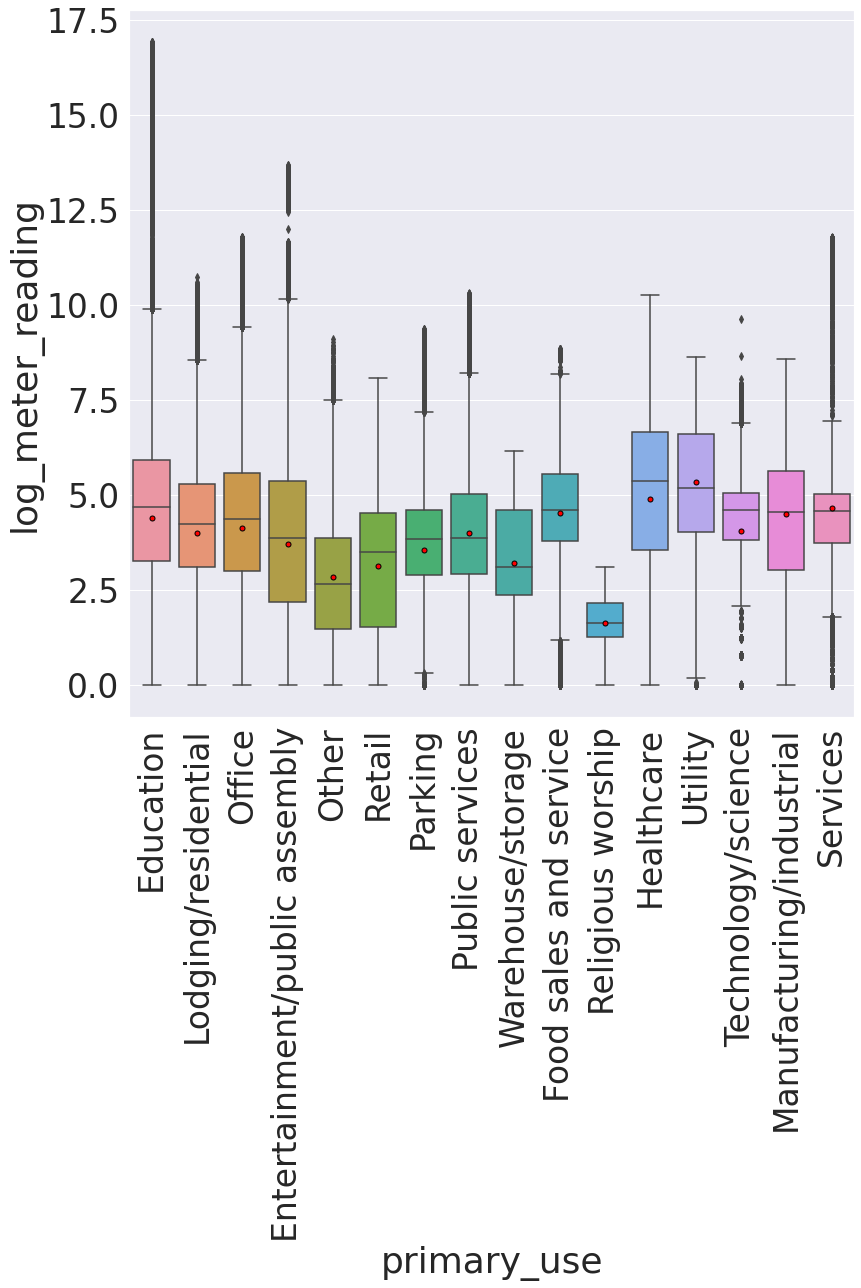

In [ ]:
plt.figure(figsize=(13,13))
sns.boxplot(x='primary_use',y='log_meter_reading',data=train_data,showmeans=True,  
                meanprops={"marker":"o","markersize":5,"markerfacecolor":"red", "markeredgecolor":"black"})
plt.xticks(rotation=90)
plt.show()

* Healthcare and utilty having highest meter readings

In [ ]:
train_data['cloud_coverage_lags_mean']=train_data['cloud_coverage'].rolling(window=3, min_periods=0).mean()
train_data['air_temperature_lags_mean']=train_data['air_temperature'].rolling(window=3,min_periods=0).mean()
train_data['dew_temperature_lags_mean']=train_data['dew_temperature'].rolling(window=3,min_periods=0).mean()
train_data['precip_depth_1_hr_lags_mean']=train_data['precip_depth_1_hr'].rolling(window=3,min_periods=0).mean()
train_data['wind_direction_lags_mean']=train_data['wind_direction'].rolling(window=3,min_periods=0).mean()
train_data['wind_speed_lags_mean']=train_data['wind_speed'].rolling(window=3,min_periods=0).mean()
train_data['sea_level_pressure_lags_mean']=train_data['sea_level_pressure'].rolling(window=3,min_periods=0).mean()

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

[]

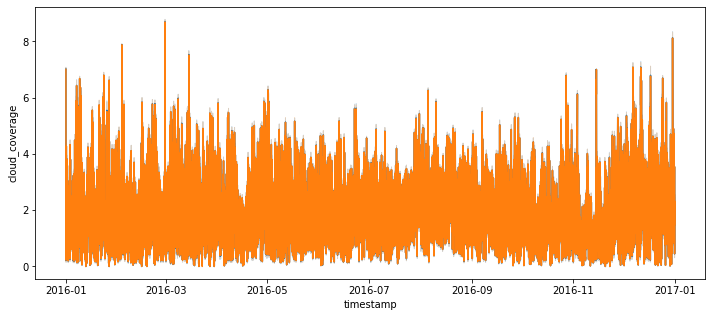

In [ ]:
plt.figure(figsize=(12,5))
sns.lineplot(x='timestamp',y='cloud_coverage',data=train_data)
sns.lineplot(x='timestamp',y='cloud_coverage_lags_mean',data=train_data)
plt.plot()

[]

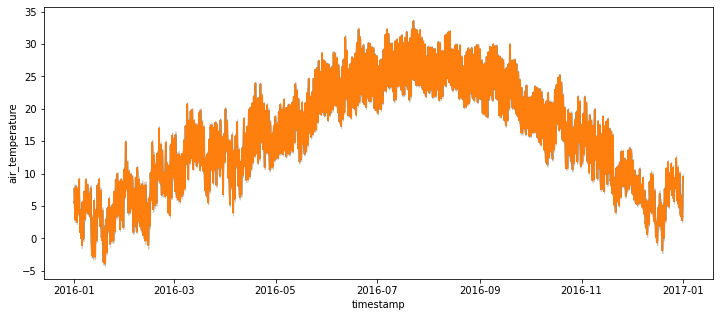

In [ ]:
plt.figure(figsize=(12,5))
sns.lineplot(x='timestamp',y='air_temperature',data=train_data)
sns.lineplot(x='timestamp',y='air_temperature_lags_mean',data=train_data)
plt.plot()


[]

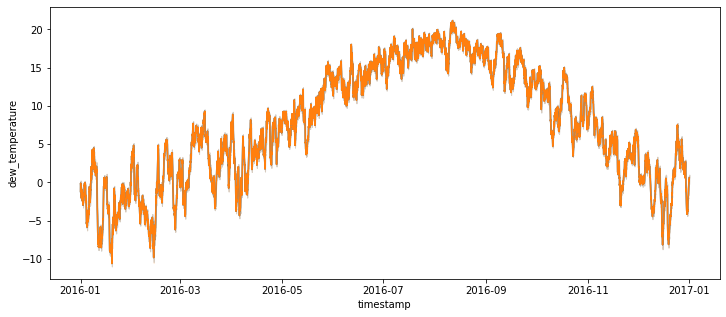

In [ ]:
plt.figure(figsize=(12,5))
sns.lineplot(x='timestamp',y='dew_temperature',data=train_data)
sns.lineplot(x='timestamp',y='dew_temperature_lags_mean',data=train_data)
plt.plot()

[]

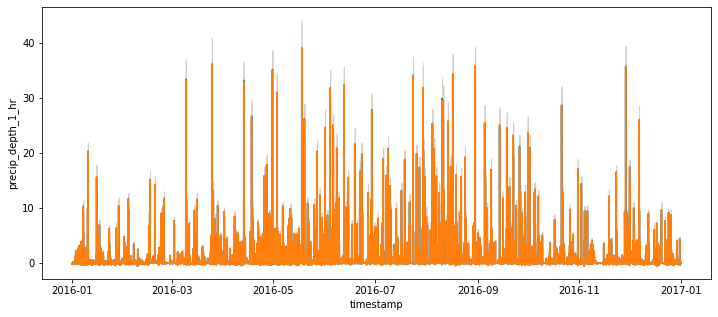

In [ ]:
plt.figure(figsize=(12,5))
sns.lineplot(x='timestamp',y='precip_depth_1_hr',data=train_data)
sns.lineplot(x='timestamp',y='precip_depth_1_hr
_lags_mean',data=train_data)
plt.plot()

In [ ]:
plt.figure(figsize=(12,5))
sns.lineplot(x='timestamp',y='dew_temperature',data=train_data)
sns.lineplot(x='timestamp',y='dew_temperature_lags_mean',data=train_data)
plt.plot()

In [ ]:
train_data.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,cloud_coverage_lags_mean,air_temperature_lags_mean,dew_temperature_lags_mean,precip_depth_1_hr_lags_mean,wind_direction_lags_mean,wind_speed_lags_mean,sea_level_pressure_lags_mean
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,6.0,25.0,20.0,NaN,0.0,0.0,1019.7
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,6.0,25.0,20.0,NaN,0.0,0.0,1019.7
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,6.0,25.0,20.0,NaN,0.0,0.0,1019.7
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,6.0,25.0,20.0,NaN,0.0,0.0,1019.7
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,6.0,25.0,20.0,NaN,0.0,0.0,1019.7
